### 1.a) Analyzing data for passengers carried by airlines in 2013-2023

#### Importing libraries and data preprocessing

In [158]:
import pandas as pd
import numpy as np

# Load and preprocess air traffic data
data = pd.read_csv('AirtrafficA4.csv', thousands=',')

data=data.dropna(axis=0)
month_map={
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUNE': 6,
    'JULY': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
data['MONTH']=data['MONTH'].str.strip()
data["#MONTH"]=data['MONTH'].map(month_map)
data = data.sort_values(by=['YEAR', '#MONTH']).reset_index(drop=True)

# Create a date index for time-series format
data['DATE']=pd.to_datetime([f'{y}-{m}-01' for y, m in zip(data['YEAR'], data['#MONTH'])])

data.head()

,AIRLINE,YEAR,MONTH,TOTAL DEPARTURES,HOURS FLOWN,KILOMETRE FLOWN,PASSENGERS CARRIED,AVAILABLE SEAT KILOMETRE (IN THOUSAND),FREIGHT CARRIED (IN TONNE),MAIL CARRIED (IN TONNE),#MONTH,DATE
0,A007,2013,JAN,10552.0,18655.0,10112.0,1408012.0,1820105.0,6465.0,0.0,1,2013-01-01
1,A007,2013,FEB,9873.0,17374.0,9439.0,1341210.0,1698930.0,6235.0,0.0,2,2013-02-01
2,A007,2013,MAR,11393.0,20093.0,11028.0,1423569.0,1984886.0,6505.0,0.0,3,2013-03-01
3,A007,2013,APR,11426.0,20084.0,11090.0,1511094.0,1996084.0,5903.0,0.0,4,2013-04-01
4,A007,2013,MAY,11885.0,20779.0,11533.0,1685168.0,2075882.0,7345.0,0.0,5,2013-05-01


#### Helper function for determining stationarity, plotting ACF, PACF

In [159]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt 

def plot(y):
    # Augmented Dickey-Fuller test to test stationarity
    ADF_statistic, p_value = sm.tsa.stattools.adfuller(y)[0:2]
    print("ADF_statistic: ", ADF_statistic)
    print("P value: ", p_value)

    # Plotting ACF and PACF
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, ax=acf_ax)
    smt.graphics.plot_pacf(y, ax=pacf_ax)
    plt.tight_layout()

ADF_statistic:  -1.778833781869466
P value:  0.39101960467496866


Text(0.5, 0.98, 'Time series, ACF, PACF of passengers carried')

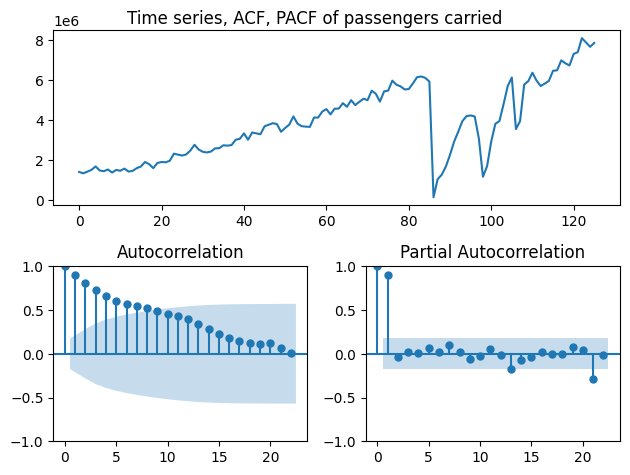

In [160]:
y=data['PASSENGERS CARRIED'].dropna()

plot(y)
plt.suptitle("Time series, ACF, PACF of passengers carried")

ADF_statistic:  -11.119217235406193
P value:  3.50005454679551e-20


Text(0.5, 0.98, 'Time series, ACF, PACF of passengers carried(diff)')

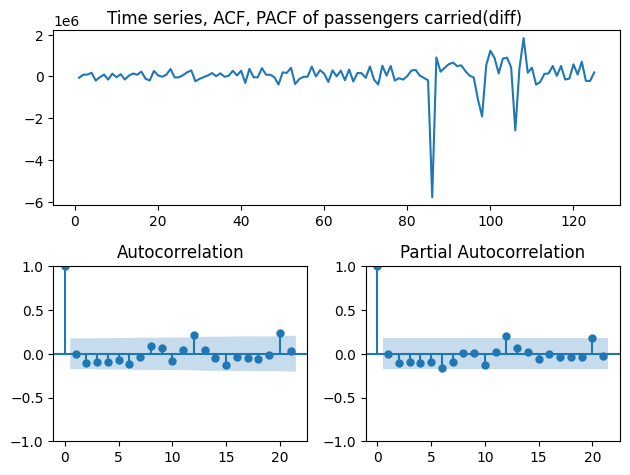

In [161]:
# Taking diff
y_diff=y.diff().dropna()
plot(y_diff)
plt.suptitle("Time series, ACF, PACF of passengers carried(diff)")

ADF_statistic:  -6.901515419692399
P value:  1.2784640950985824e-09


Text(0.5, 0.98, 'Time series, ACF, PACF of passengers carried(diff2)')

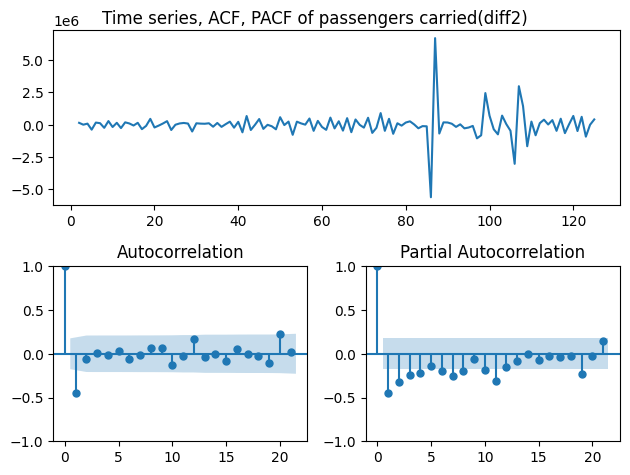

In [162]:
# Taking further difference
y_diff2=y_diff.diff().dropna()
plot(y_diff2)
plt.suptitle("Time series, ACF, PACF of passengers carried(diff2)")

ADF_statistic:  -11.128434929960303
P value:  3.3286209245175934e-20


Text(0.5, 0.98, 'Time series, ACF, PACF of passengers carried(diff+shift)')

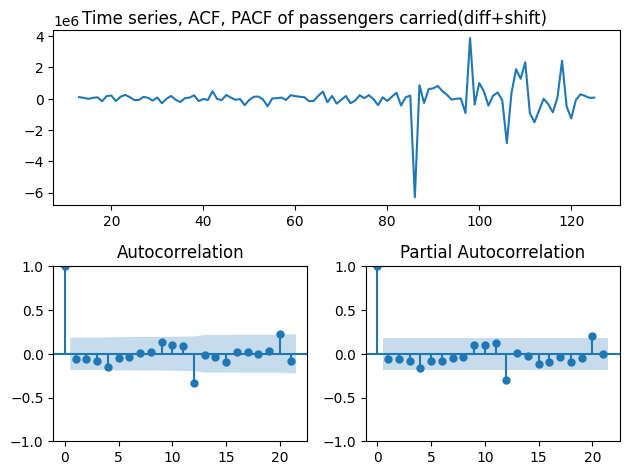

In [163]:
# Removing seasonality
y_shift=(y_diff-y_diff.shift(12)).dropna()
# Seasonality 6

plot(y_shift)
plt.suptitle("Time series, ACF, PACF of passengers carried(diff+shift)")

#### Taking different models (SARIMAX, AutoARIMA), training on train data and then comparing MAPE score

In [164]:
# data['COVID'] = ((data['YEAR'] >= 2020) & (data['YEAR'] <= 2021)).astype(int)

# Train-test split
train_size = int(0.6 * len(y))
train, test = y[:train_size], y[train_size:]

                                     SARIMAX Results                                      
Dep. Variable:                 PASSENGERS CARRIED   No. Observations:                   75
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -835.467
Date:                            Mon, 28 Oct 2024   AIC                           1680.934
Time:                                    02:03:01   BIC                           1691.569
Sample:                                         0   HQIC                          1685.109
                                             - 75                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7993      0.154      5.179      0.000       0.497       1.102
ma.L1         -0.9937      0.498   

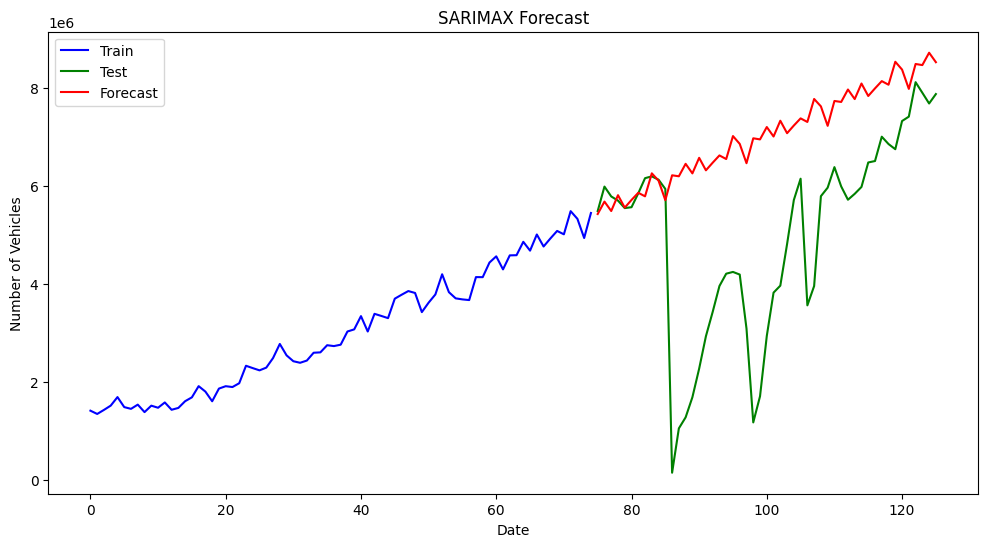

In [165]:
#Trying to fit a seasonal ARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sktime.performance_metrics.forecasting import (mean_absolute_scaled_error, mean_absolute_percentage_error)


# Fit the SARIMAX model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  # Adjust parameters as needed
model_fit = model.fit()
# print(model_fit.summary())

# Forecasting
forecast = model_fit.forecast(steps=len(test))

# Calculate MAPE
mape = mean_absolute_percentage_error(test, forecast)

# Calculate MASE
mase = mean_absolute_scaled_error(test, forecast, y_train=train)

# Print metrics
print("MAPE: ", mape)
print("MASE: ", mase)

# Plotting the results
plt.figure(figsize=(12, 6))
train.plot(label='Train', color='b')
test.plot(label='Test', color='g')
forecast.index = test.index  # Align forecast index
forecast.plot(label='Forecast', color='r')

plt.legend()
plt.title("SARIMAX Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Vehicles")
plt.show()

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                   75
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 6)   Log Likelihood               -1000.432
Date:                                Mon, 28 Oct 2024   AIC                           2012.864
Time:                                        02:03:13   BIC                           2026.688
Sample:                                             0   HQIC                          2018.378
                                                 - 75                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.306e+04   4.67e+04      1.778      0.075   -8475.184    1.75e+05
ma.

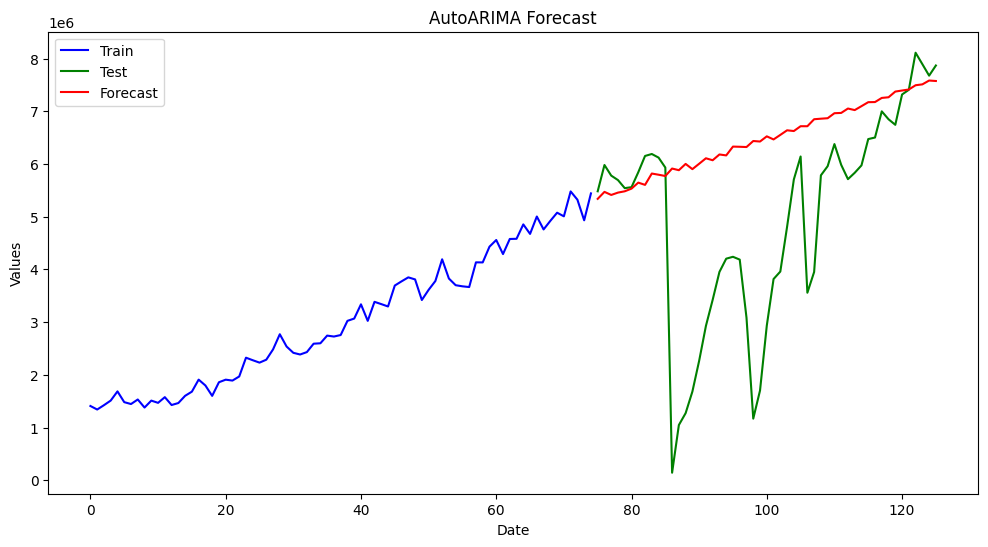

In [166]:
from sktime.forecasting.arima import AutoARIMA

forecaster = AutoARIMA(
    suppress_warnings=True,
    start_p=0,
    max_p=7,
    start_q=0,
    max_q=7,
    seasonal=True,
    sp=6
)

# Fit the model
forecaster.fit(train)

# Forecasting
fh = np.arange(1, len(test) + 1)  # Forecast horizon
forecast = forecaster.predict(fh=fh)
# print(forecaster.summary())

# Calculate error metrics
mase = mean_absolute_scaled_error(test, forecast, y_train=train)
mape = mean_absolute_percentage_error(test, forecast)
print("MASE: ", mase, " MAPE: ", mape)

# Plotting the results
plt.figure(figsize=(12, 6))
train.plot(label="Train", color="b")
test.plot(label="Test", color="g")
forecast.index = test.index 
forecast.plot(label="Forecast", color="r")

plt.legend()
plt.title("AutoARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()

#### Using Linear Interpolation to remove the effect of outliers during the covid period

In [167]:
y_pol=y
y_pol.loc[80:116] = np.nan

# Apply interpolation over the whole column (only affects NaNs)
y_pol = y_pol.interpolate(method='linear')
y=data['PASSENGERS CARRIED'].dropna()

#### Final forecast on the next 12 month  period

predictions for next week
126    7.826535e+06
127    7.887707e+06
128    7.797784e+06
129    7.916200e+06
130    8.035613e+06
131    7.982799e+06
132    8.026434e+06
133    8.023248e+06
134    8.166078e+06
135    8.127192e+06
136    8.073251e+06
137    8.126409e+06
Name: predicted_mean, dtype: float64


<Axes: >

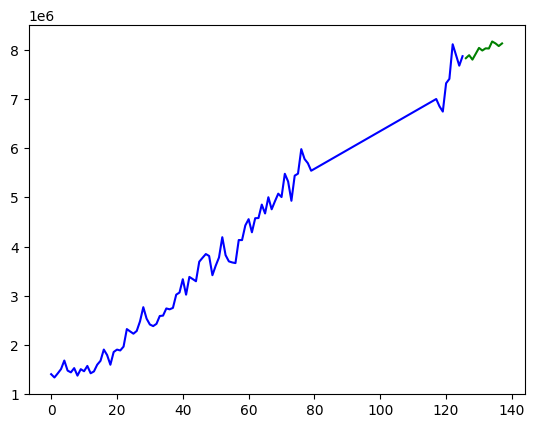

In [168]:
# Fit the SARIMAX model
forecaster = SARIMAX(y, order=(0, 1, 1), seasonal_order=(1, 0, 2, 6))  # Adjust parameters as needed

pred=np.arange(128, 140)

# Fit the model
model_fit = forecaster.fit()
pred = model_fit.forecast(steps=len(pred))

print("predictions for next week")
print(pred)

months=['2023 SEP', '2023 OCT', '2023 NOV', '2023 DEC', '2024 JAN', '2024 FEB', '2024 MAR', '2024 APR', '2024 MAY', '2024 JUN', '2024 JUL', '2024 AUG']
submission=pd.DataFrame(list(zip(months, pred)), columns=['YEAR_MONTH', 'PASSENGERS CARRIED'])
submission.to_csv("submission.csv", index=False)

y_pol.plot(label='total', color='b')
pred.plot(label='pred', color='g')

### 1.b) Use an LLM to generate predictions
Your input to the LLM should be PROMPT + string generated from timeseries dataframe

In [169]:
# Tokenize the data
y_token=[]
for d in y_pol:
    d_str=f"{d:.7}".rstrip('e+06').replace('.', '')
    d_str = d_str.ljust(7, '0')
    d_str=' '.join(d_str)
    y_token.append(d_str)

y_token=', '.join(y_token)
print(y_token)


1 4 0 8 0 1 2, 1 3 4 1 2 1 0, 1 4 2 3 5 6 9, 1 5 1 1 0 9 4, 1 6 8 5 1 6 8, 1 4 8 0 8 7 9, 1 4 4 5 2 4 8, 1 5 3 1 4 0 0, 1 3 7 8 6 9 1, 1 5 1 0 1 8 4, 1 4 6 7 7 6 3, 1 5 7 5 8 7 2, 1 4 2 6 5 8 0, 1 4 6 4 0 7 0, 1 6 0 1 1 4 1, 1 6 7 9 9 6 3, 1 9 0 8 3 3 4, 1 7 9 7 1 0 1, 1 5 9 9 9 7 7, 1 8 5 8 6 6 4, 1 9 0 7 3 7 8, 1 8 9 0 2 7 3, 1 9 6 7 9 9 2, 2 3 2 4 2 2 1, 2 2 7 6 4 0 4, 2 2 3 0 6 4 5, 2 2 8 6 1 2 8, 2 4 8 1 2 8 5, 2 7 6 9 2 8 3, 2 5 3 6 5 5 4, 2 4 1 6 9 1 0, 2 3 8 4 9 4 3, 2 4 3 0 4 4 9, 2 5 8 9 8 6 1, 2 5 9 7 7 6 5, 2 7 4 3 3 2 5, 2 7 2 5 7 1 1, 2 7 5 4 1 3 1, 3 0 2 3 2 2 8, 3 0 6 6 5 5 0, 3 3 3 6 8 3 9, 3 0 2 3 0 8 1, 3 3 8 3 7 6 8, 3 3 4 1 0 8 1, 3 2 9 5 8 2 0, 3 6 9 2 8 2 8, 3 7 7 2 5 8 3, 3 8 4 8 3 2 2, 3 8 0 9 2 2 8, 3 4 1 8 6 0 5, 3 6 1 1 3 7 1, 3 7 7 8 7 8 0, 4 1 9 0 9 1 4, 3 8 2 5 8 1 4, 3 6 9 9 4 5 1, 3 6 7 8 2 4 5, 3 6 6 4 5 0 9, 4 1 3 3 0 2 7, 4 1 3 1 8 4 4, 4 4 3 0 0 7 0, 4 5 5 6 9 0 4, 4 2 9 0 1 8 9, 4 5 7 6 2 3 0, 4 5 7 9 9 1 0, 4 8 5 2 9 0 9, 4 6 7 2 6 8 0, 5 0 0 2 4 

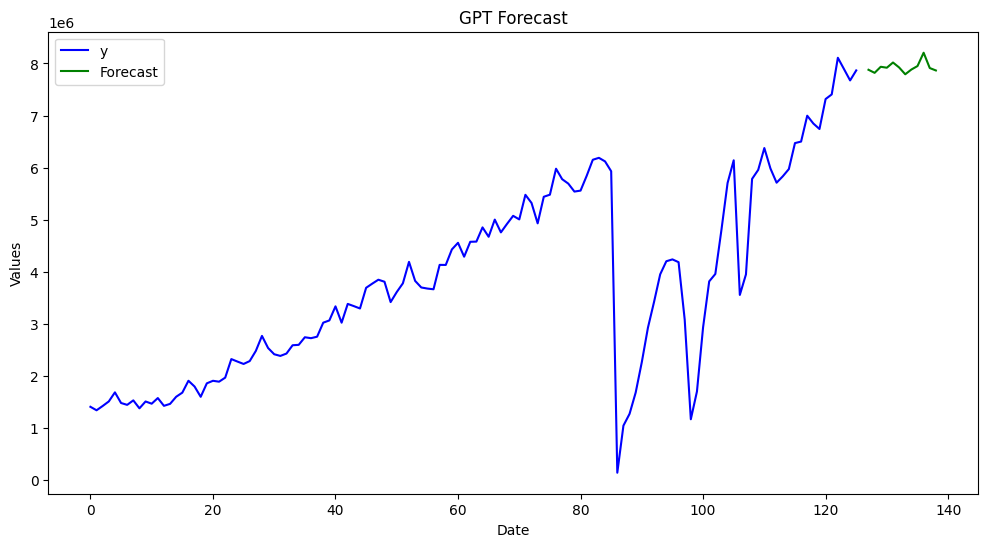

In [170]:
# Given the dataset (passengers carried by an airline over the years 2013 Jan-2023 Aug) below,  
#     forecast next 12 values of the time series. 
# (y_tokens)

#     Return the answer in JSON format, containing two keys: '{time_idx}' 
#     and '{forecast_col}', and list of values assigned to them. 
#     Return only the forecasts, not the Python code.


# ChatGPT said:

# {
#     "time_idx": [127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138],
    # "forecast_col": [
    #     7879448.797360663,
    #     7820390.150911682,
    #     7936876.144944265,
    #     7918937.200867041,
    #     8018894.378393498,
    #     7923624.878678311,
    #     7792785.668688422,
    #     7883954.739400877,
    #     7950816.722030679,
    #     8206739.740450005,
    #     7912619.781882194,
    #     7866005.377980492
    # ]
# }


gpt_forecast=pd.Series([
    7879448.797360663,
    7820390.150911682,
    7936876.144944265,
    7918937.200867041,
    8018894.378393498,
    7923624.878678311,
    7792785.668688422,
    7883954.739400877,
    7950816.722030679,
    8206739.740450005,
    7912619.781882194,
    7866005.377980492
])
gpt_forecast.index=pd.Series([127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138])

# Plotting the results
plt.figure(figsize=(12, 6))
y.plot(label='y', color='b')
gpt_forecast.plot(label="Forecast", color="g")

plt.legend()
plt.title("GPT Forecast")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()

### 1.c) Train a Global Model (Prophet)

02:03:14 - cmdstanpy - INFO - Chain [1] start processing
02:03:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


            ds          yhat
126 2023-08-31  6.042406e+06
127 2023-09-30  6.420072e+06
128 2023-10-31  6.618706e+06
129 2023-11-30  6.924432e+06
130 2023-12-31  6.649782e+06
131 2024-01-31  6.564010e+06
132 2024-02-29  6.783195e+06
133 2024-03-31  6.735540e+06
134 2024-04-30  6.503668e+06
135 2024-05-31  6.412053e+06
136 2024-06-30  6.484127e+06
137 2024-07-31  6.616039e+06


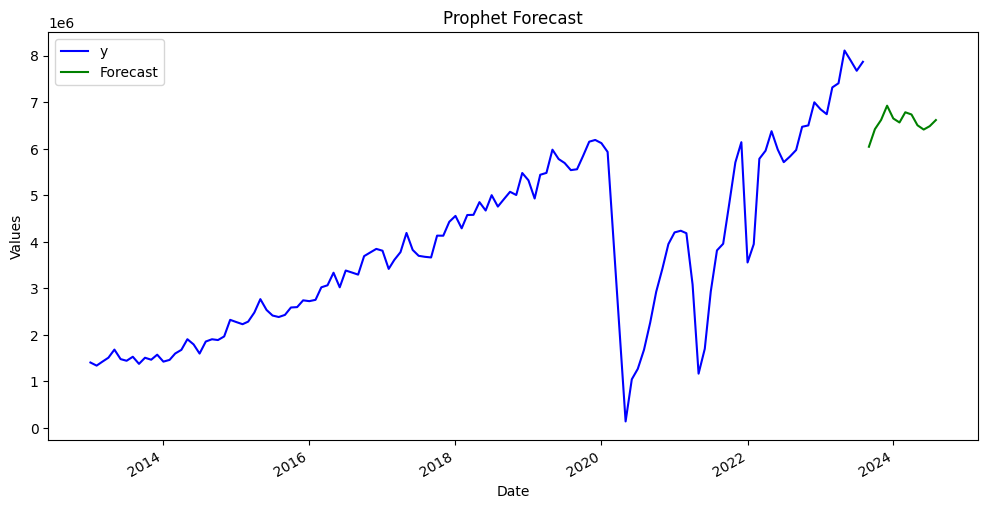

In [171]:
from prophet import Prophet

# Create a DataFrame suitable for Prophet
df_prophet=pd.DataFrame()
df_prophet['y']=y
df_prophet['ds']=data['DATE']

# Train the model
model = Prophet(yearly_seasonality=True)
model.fit(df_prophet)

# Predict for Sep 2023 to Aug 2024
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Extract relevant forecasted values
predictions = forecast[['ds', 'yhat']].tail(12)
print(predictions)
#             ds          yhat
# 126 2023-08-31  6.042406e+06
# 127 2023-09-30  6.420072e+06
# 128 2023-10-31  6.618706e+06
# 129 2023-11-30  6.924432e+06
# 130 2023-12-31  6.649782e+06
# 131 2024-01-31  6.564010e+06
# 132 2024-02-29  6.783195e+06
# 133 2024-03-31  6.735540e+06
# 134 2024-04-30  6.503668e+06
# 135 2024-05-31  6.412053e+06
# 136 2024-06-30  6.484127e+06
# 137 2024-07-31  6.616039e+06

prophet_forecast=predictions['yhat']
prophet_forecast.index=pd.DatetimeIndex(predictions['ds'])
y.index=data['DATE']

# Plotting the results
plt.figure(figsize=(12, 6))
y.plot(label='y', color='b')
prophet_forecast.plot(label="Forecast", color="g")

plt.legend()
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()

02:03:34 - cmdstanpy - INFO - Chain [1] start processing
02:03:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\sagni\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


            ds          yhat
126 2023-08-31  7.240524e+06
127 2023-09-30  7.916970e+06
128 2023-10-31  8.283024e+06
129 2023-11-30  8.747879e+06
130 2023-12-31  8.143012e+06
131 2024-01-31  7.394197e+06
132 2024-02-29  7.938122e+06
133 2024-03-31  7.767246e+06
134 2024-04-30  7.472996e+06
135 2024-05-31  7.396513e+06
136 2024-06-30  7.540277e+06
137 2024-07-31  7.786391e+06


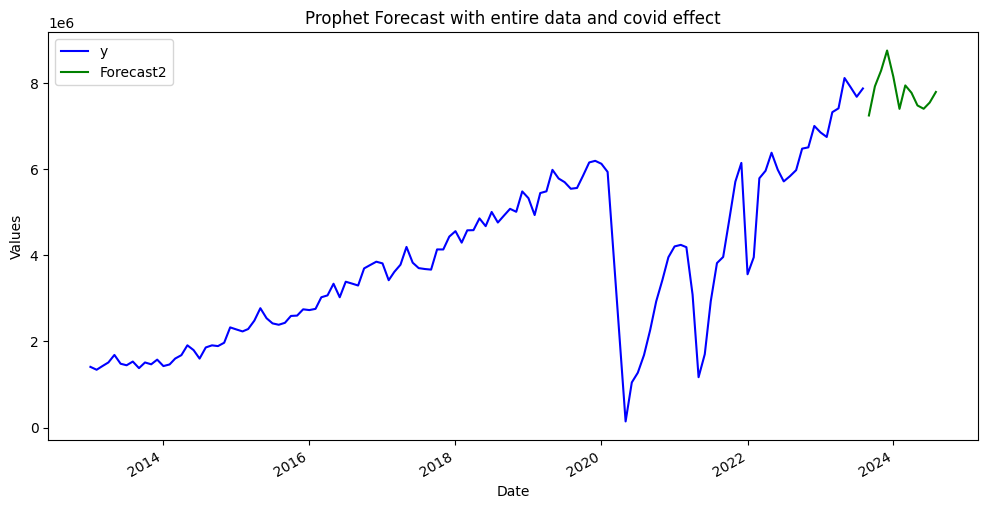

In [173]:
# Training Prophet model on whole data
df_prophet=data.rename(columns={'DATE':'ds', 'PASSENGERS CARRIED': 'y'})
df_prophet['ds']=data['DATE']

# Add a COVID-19 period regressor (optional)
df_prophet['covid_effect'] = ((df_prophet['ds'] >= '2020-03-01') & 
                              (df_prophet['ds'] <= '2022-01-01')).astype(int)

# Initialize the Prophet model with seasonal adjustments
model = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')

# Add the COVID regressor to the model
model.add_regressor('covid_effect')

# Train the model
model.fit(df_prophet)

# Make future predictions (Sep 2023 - Aug 2024)
future = model.make_future_dataframe(periods=12, freq='M')
future['covid_effect'] = 0  # Assume no COVID effect in the future

# Predict and extract relevant forecasted values
forecast = model.predict(future)
predictions = forecast[['ds', 'yhat']].tail(12)
print(predictions)
#            ds          yhat
# 126 2023-08-31  7.240524e+06
# 127 2023-09-30  7.916970e+06
# 128 2023-10-31  8.283024e+06
# 129 2023-11-30  8.747879e+06
# 130 2023-12-31  8.143012e+06
# 131 2024-01-31  7.394197e+06
# 132 2024-02-29  7.938122e+06
# 133 2024-03-31  7.767246e+06
# 134 2024-04-30  7.472996e+06
# 135 2024-05-31  7.396513e+06
# 136 2024-06-30  7.540277e+06
# 137 2024-07-31  7.786391e+06

prophet_forecast2=predictions['yhat']
prophet_forecast2.index=pd.DatetimeIndex(predictions['ds'])

# Plotting the results
plt.figure(figsize=(12, 6))
y.plot(label='y', color='b')
prophet_forecast2.plot(label="Forecast2", color="g")

plt.legend()
plt.title("Prophet Forecast with entire data and covid effect")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()